# __スクラッチで線形回帰を実装する(試行錯誤日記)__

## __ライブラリのimport__

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## __データの読み込み__

In [2]:
train = pd.read_csv('../../input/house_price/train.csv')

説明変数（x_train）と目的変数（y_train）に分ける。

In [3]:
X = train[["GrLivArea","YearBuilt"]]
y = train['SalePrice']

## **データの可視化**

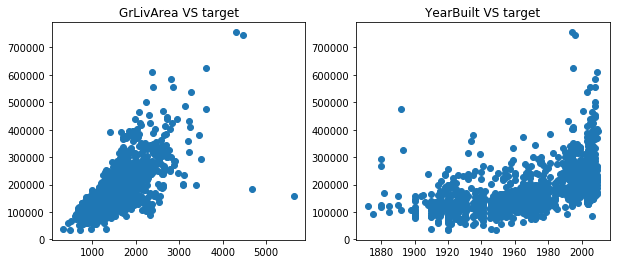

In [4]:
plt.figure(figsize =(10,4))
plt.subplot(1,2,1)
plt.scatter(X["GrLivArea"], y)
plt.title("GrLivArea VS target")
plt.subplot(1,2,2)
plt.scatter(X["YearBuilt"],y)
plt.title("YearBuilt VS target");

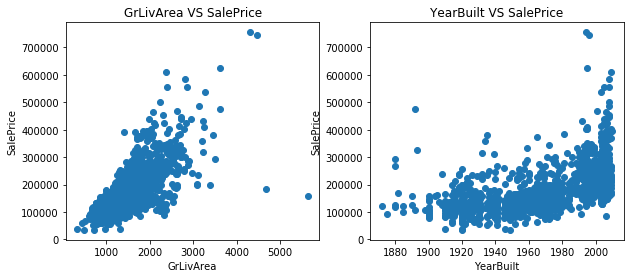

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i,col in enumerate(["GrLivArea","YearBuilt"]):
    ax[i].scatter(X[col], y)
    ax[i].set_xlabel("{}".format(col))
    ax[i].set_ylabel("SalePrice")
    ax[i].set_title("{} VS SalePrice".format(col));

## **テストデータの分割**

__random__  
[https://docs.python.org/ja/3/library/random.html]('randomの一覧')

__np.ceil()__  
小数点以下切り上げ

__np.floor()__  
小数点以下切り捨て

__pandas,DataFrame.iloc__  
行と列を番号で指定。(インデックスではない)

In [6]:
type(X)

pandas.core.frame.DataFrame

### **失敗(Pandasで入ってpandasで返っている。)**

In [7]:
def train_test_split(X, y, train_size=0.8, shuffle = False):
    """
    学習用データを分割する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, )
      正解値
    train_size : float (0<train_size<1)
      何割をtrainとするか指定

    Returns
    ----------
    X_train : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    X_test : 次の形のndarray, shape (n_samples, n_features)
      検証データ
    y_train : 次の形のndarray, shape (n_samples, )
      学習データの正解値
    y_test : 次の形のndarray, shape (n_samples, )
      検証データの正解値
    """
    sel_num = int(len(X) * train_size)# trainデータに選ぶサンプル数の決定
    if shuffle == True:
        all_num = np.arange(len(X)) # 全てのサンプル数
        train_num = np.random.choice(all_num, size= sel_num, replace=False) # trainに選ぶインデックスを選択
        test_num = np.delete(all_num, train_num) # trainデータに選ばれなかったindexを取得
        X_train, X_test, y_train, y_test = X.iloc[train_num], X.iloc[test_num, :],  y[train_num], y[test_num]
    
    else:
        X_train, X_test, y_train, y_test = X.iloc[:sel_num,:],X.iloc[sel_num:,:], y.iloc[:sel_num,:], y.iloc[sel_num:,:]
        


    return X_train, X_test, y_train, y_test

### **成功random.shuffleを使ってシャッフルも実装**

In [8]:
def train_test_split(X, y, train_size = 0.8, shuffle=False):
    sel_num = int(len(X) * train_size)
    if shuffle:
        data = np.concatenate([X,y[:,np.newaxis]], axis=1)
        np.random.shuffle(data)
        X_train, X_test, y_train, y_test = data[:sel_num, :-1],data[sel_num:, :-1], data[:sel_num, -1], data[sel_num:, -1]
    else:
        X_train, X_test, y_train, y_test = X[:sel_num], X[sel_num:], y[:sel_num], y[sel_num:]
    return X_train, X_test, y_train, y_test

- shuffleなし

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size = 0.8, shuffle=False)

In [10]:
print(X_train[0], X_test[0], y_train[0], y_test[0])

[1710 2003] [2108 1935] 208500 235000


In [11]:
print("X:{},y:{}, X_train:{}, X_test:{}, y_train:{}, y_test:{}".format(
    X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X:(1460, 2),y:(1460,), X_train:(1168, 2), X_test:(292, 2), y_train:(1168,), y_test:(292,)


- shuffle有り

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle=True)

In [13]:
print(X_train[0], X_test[0], y_train[0], y_test[0])

[1616 2005] [1056 1955] 232000 145000


In [14]:
print("X:{},y:{}, X_train:{}, X_test:{}, y_train:{}, y_test:{}".format(
    X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X:(1460, 2),y:(1460,), X_train:(1168, 2), X_test:(292, 2), y_train:(1168,), y_test:(292,)


１168＋292＝1460　なので全データ使われていることが確認できる。

## __スケーリングする(標準化)__
__標準化__  
\begin{align}
z=\dfrac {x-\mu}{\sigma }
\end{align}
この式を実装する。

In [15]:
# 無名関数の適用
X = train[["GrLivArea", "YearBuilt"]]
p1 = time.time()
mean = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
z1 = lambda x:(x - mean) / sigma
X_scaled = X.apply(z1)
p2 = time.time()

# 直接計算
p3 = time.time()
mean = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
z2 = (X - mean) / sigma
p4 =time.time()

print('かかった時間：　{}'.format(p2-p1))
print('かかった時間：　{}'.format(p4-p3))

かかった時間：　0.02532196044921875
かかった時間：　0.0038499832153320312


データに対して直接計算してスケーリングした方を使ってクラス化すると以下のようになる。

- クラス化する（ScratchStandardScaler()）

In [16]:
class ScratchStandardScaler():
    """
    標準化する。
    """


    def fit(self, X):
        """
        標準化のために平均と標準偏差を計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        """
        self.mean = np.mean(X, axis=0) # 平均の計算
        self.sigma = np.std(X, axis=0) # 分散の計算

    def transform(self, X):
        """
        fitで求めた値を使い標準化を行う。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          特徴量

        Returns
        ----------
        X_scaled : 次の形のndarray, shape (n_samples, n_features)
          標準化された特緒量
        """
        X_scaled = (X - self.mean) / self.sigma # 標準化
        
        return X_scaled
    

In [17]:
scaler = ScratchStandardScaler()

In [18]:
scaler.fit(X_train)
scaler.transform(X_train)

array([[ 0.23380274,  1.11628094],
       [ 0.63679647, -0.21380438],
       [ 0.81656329,  0.71725534],
       ...,
       [ 1.35586373,  1.21603734],
       [-0.97320302, -0.54632571],
       [-0.92776745, -1.47738544]])

In [19]:
print('平均値\n{}'.format(scaler.mean))
print('標準偏差\n{}'.format(scaler.sigma))

平均値
[1497.64640411 1971.42979452]
標準偏差
[506.21133961  30.07325877]


### **sklearnのStandardScalerと比較してみる**
- ほとんど同じ値になっているので成功

In [20]:
skscaler = StandardScaler()
skscaler.fit_transform(X_train)

array([[ 0.23380274,  1.11628094],
       [ 0.63679647, -0.21380438],
       [ 0.81656329,  0.71725534],
       ...,
       [ 1.35586373,  1.21603734],
       [-0.97320302, -0.54632571],
       [-0.92776745, -1.47738544]])

In [21]:
print('平均値\n{}'.format(scaler.mean))
print('標準偏差\n{}'.format(scaler.sigma))

平均値
[1497.64640411 1971.42979452]
標準偏差
[506.21133961  30.07325877]


## **線形回帰の実装**
ここから`xsample`, `ysample`の2つのデータセットを使って実験していく

In [22]:
xsample = scaler.transform(X_train)
ysample = y_train

In [23]:
xsample

array([[ 0.23380274,  1.11628094],
       [ 0.63679647, -0.21380438],
       [ 0.81656329,  0.71725534],
       ...,
       [ 1.35586373,  1.21603734],
       [-0.97320302, -0.54632571],
       [-0.92776745, -1.47738544]])

In [24]:
ysample

array([232000, 201800, 215000, ..., 335000, 115000, 115000])

### __仮定関数を設定する。__

特徴量の数だけ、係数を用意する。  
`np.newaxis`で列ベクトルにしている。

In [25]:
n_theta = np.random.randn(xsample.shape[1])
linear = np.dot(n_theta, xsample.T)
linear = linear[:, np.newaxis]

In [26]:
linear

array([[ 1.69765077],
       [ 0.03331929],
       [ 1.44126749],
       ...,
       [ 2.42851925],
       [-1.28253003],
       [-2.57203323]])

- 2つの処理方法

In [27]:
xsample.shape

(1168, 2)

In [28]:
# 線型結合１
np.dot(n_theta, xsample.T)

array([ 1.69765077,  0.03331929,  1.44126749, ...,  2.42851925,
       -1.28253003, -2.57203323])

In [29]:
# 線型結合２
np.dot(xsample, n_theta)

array([ 1.69765077,  0.03331929,  1.44126749, ...,  2.42851925,
       -1.28253003, -2.57203323])

In [30]:
# ２つで時間の比較(転置しないほうが早い)
p1 = time.time()
np.dot(n_theta, xsample.T)
p2 = time.time()
p3 =time.time()
np.dot(xsample, n_theta)
p4=time.time()
print('かかった時間：　{}'.format(p2-p1))
print('かかった時間：　{}'.format(p4-p3))

かかった時間：　7.390975952148438e-05
かかった時間：　4.601478576660156e-05


In [31]:
linear.shape

(1168, 1)

- バイアス項を加える。  
hstackを使うと要素が１の列を元々のデータセットに右から結合させることができる。

In [32]:
a = xsample
b = np.ones(xsample.shape[0])

In [33]:
print(a.shape,b.shape,b[:, np.newaxis].shape)

(1168, 2) (1168,) (1168, 1)


In [34]:
np.hstack((a,b[:,np.newaxis]))

array([[ 0.23380274,  1.11628094,  1.        ],
       [ 0.63679647, -0.21380438,  1.        ],
       [ 0.81656329,  0.71725534,  1.        ],
       ...,
       [ 1.35586373,  1.21603734,  1.        ],
       [-0.97320302, -0.54632571,  1.        ],
       [-0.92776745, -1.47738544,  1.        ]])

- 関数化する

In [35]:
n_theta = np.random.randn(xsample.shape[1])
def _linear_hypothesis(X):
    """
    線形の仮定関数を計算する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ

    Returns
    -------
      次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果

    """
    linear = np.dot(X, n_theta)
    linear = linear[:, np.newaxis]
    return linear

In [36]:
_linear_hypothesis(xsample)

array([[-0.13143638],
       [-0.65389112],
       [-0.74833309],
       ...,
       [-1.24029119],
       [ 0.91993838],
       [ 0.79000793]])

## __目的関数__

__平均二乗誤差__
\begin{align}
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m}. (h_\theta(x^{(i)})-y^{(i)})^2.
\end{align}
  
  この関数を実装する。

In [37]:
def MSE(y_pred, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = np.average(np.square(y_pred-y), axis=0)/2
    return mse

## __誤差の計算__
平均二乗誤差を呼び出す形にする。

In [38]:
def _compute_cost(X, y):
    """
    平均二乗誤差を計算する。MSEは共通の関数を作っておき呼び出す

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値

    Returns
    -------
      次の形のndarray, shape (1,)
      平均二乗誤差
    """
    y_pred = _linear_hypothesis(X).ravel()
    y = y
    
    return MSE(y_pred, y)

In [39]:
_linear_hypothesis(xsample).ravel()

array([-0.13143638, -0.65389112, -0.74833309, ..., -1.24029119,
        0.91993838,  0.79000793])

In [40]:
_compute_cost(xsample,y_train)

19505776580.52858

## __最急降下法__

\begin{align}
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
\end{align}

In [41]:
 _linear_hypothesis(xsample)

array([[-0.13143638],
       [-0.65389112],
       [-0.74833309],
       ...,
       [-1.24029119],
       [ 0.91993838],
       [ 0.79000793]])

- (実際の値-予測値)  
$h_\theta(x^{(i)}) - y^{(i)}$

In [42]:
ysample -_linear_hypothesis(xsample).ravel()

array([232000.13143638, 201800.65389112, 215000.74833309, ...,
       335001.24029119, 114999.08006162, 114999.20999207])

In [43]:
_linear_hypothesis(xsample).ravel() - ysample

array([-232000.13143638, -201800.65389112, -215000.74833309, ...,
       -335001.24029119, -114999.08006162, -114999.20999207])

In [44]:
diff = ysample -_linear_hypothesis(xsample).ravel()
# diff = _linear_hypothesis(xsample).ravel() - ysample

In [45]:
diff

array([232000.13143638, 201800.65389112, 215000.74833309, ...,
       335001.24029119, 114999.08006162, 114999.20999207])

- 転置したデータ全体に誤差を掛ける。  
$(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}$

In [46]:
xsample.T

array([[ 0.23380274,  0.63679647,  0.81656329, ...,  1.35586373,
        -0.97320302, -0.92776745],
       [ 1.11628094, -0.21380438,  0.71725534, ...,  1.21603734,
        -0.54632571, -1.47738544]])

In [47]:
(diff * xsample.T).shape

(2, 1168)

- 平均をとって学習率を掛ける  
$ \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]$

In [48]:
np.average(diff*xsample.T, axis =1) #axis指定を忘れない

array([58148.86195922, 43012.9136672 ])

In [49]:
0.1 * np.average(diff*xsample.T, axis=1)

array([5814.88619592, 4301.29136672])

In [50]:
diff = ysample -_linear_hypothesis(xsample).ravel()
n_theta = n_theta - 0.1 * np.average(diff * xsample.T, axis=1)
n_theta

array([-5815.88251055, -4301.20043557])

- 上記をまとめて関数化する  
イテレーション回数は自分で決める。

In [51]:
num_iter = 15

def _gradient_descent(X, y):
    """
    最急降下法で重みを更新する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値

    Returns
    -------
      次の形のndarray, shape (1,)
      
    """
    n_theta = np.random.randn(X.shape[1])
    for i in range(num_iter):
        diff = _linear_hypothesis(X).ravel() - y
        n_theta = n_theta - 0.1 * np.average(diff * X.T, axis=1)
        
        
        print(n_theta)
        plt.subplot(1,2,1)
        plt.plot(i,n_theta[0], marker='o')
        plt.subplot(1,2,2)
        plt.plot(i, n_theta[1], marker='o')
        
    return n_theta

[6490.77630633 4857.22146317]
[12980.90321694  9715.38477869]
[19471.03012755 14573.54809421]
[25961.15703816 19431.71140972]
[32451.28394876 24289.87472524]
[38941.41085937 29148.03804076]
[45431.53776998 34006.20135628]
[51921.66468058 38864.3646718 ]
[58411.79159119 43722.52798732]
[64901.9185018  48580.69130284]
[71392.04541241 53438.85461836]
[77882.17232301 58297.01793387]
[84372.29923362 63155.18124939]
[90862.42614423 68013.34456491]
[97352.55305484 72871.50788043]


array([97352.55305484, 72871.50788043])

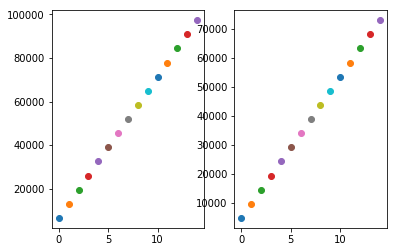

In [52]:
_gradient_descent(xsample,ysample)

ムムム！   
__n_theta__が収束しないぞ？？  
グラフを見ると一定の割合で増加しているので何かが__定数__になってしまっている。（更新されるべきものが更新されていない。）  
上の出力を見るとn_theta更新されている。とすると、更新に関係するのは`_linear_hypothesis`。  
`print`して見てみよう。

In [53]:
def _gradient_descent(X, y):
    n_theta = np.random.randn(X.shape[1])
    for i in range(num_iter):
        diff = _linear_hypothesis(X).ravel() - y
        print( _linear_hypothesis(X)[0])
        n_theta = n_theta - 0.1 * np.average(diff * X.T, axis=1)
        
    return
_gradient_descent(xsample,ysample)

[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]
[-6161.11729216]


予想通りここが更新されていない。  
というのも当たり前で、関数内で他の関数のlocal変数を更新することはできないのである。
では、関数内でグローバル変数に値を代入してみよう。

In [54]:
def _gradient_descent(X, y):
    
    global n_theta
    n_theta = np.random.randn(X.shape[1])
    for i in range(num_iter):
        diff = _linear_hypothesis(X).ravel() - y
        n_theta = n_theta - 0.1 * np.average(diff * X.T, axis=1)
        
        
        print('n_theta:  {}   linear_hypothesis{}'.format(n_theta,_linear_hypothesis(X)[0]))
        plt.subplot(1,2,1)
        plt.plot(i,n_theta[0], marker='o')
        plt.subplot(1,2,2)
        plt.plot(i, n_theta[1], marker='o')
        
    return n_theta

n_theta:  [5815.60908828 4301.47368357]   linear_hypothesis[6161.35838681]
n_theta:  [10955.08065696  8045.84649063]   linear_hypothesis[11542.75288361]
n_theta:  [15498.99171929 11303.7607224 ]   linear_hypothesis[16241.8792707]
n_theta:  [19517.50130693 14136.84323225]   linear_hypothesis[20343.93380319]
n_theta:  [23072.40931296 16599.02898318]   linear_hypothesis[23923.5720362]
n_theta:  [26218.16006036 18737.51243493]   linear_hypothesis[27046.20547711]
n_theta:  [29002.72477671 20593.5819183 ]   linear_hypothesis[29769.13930671]
n_theta:  [31468.37763539 22203.35133728]   linear_hypothesis[32142.57060498]
n_theta:  [33652.37824413 23598.40178631]   linear_hypothesis[34210.46414383]
n_theta:  [35587.57189993 24806.34413003]   linear_hypothesis[36011.32072537]
n_theta:  [37302.9175563  25851.31224176]   linear_hypothesis[37578.85121487]
n_theta:  [38823.95224305 26754.39541038]   linear_hypothesis[38942.56781093]
n_theta:  [40173.19961926 27534.01738398]   linear_hypothesis[40128.3

array([42433.47365296, 28785.19738253])

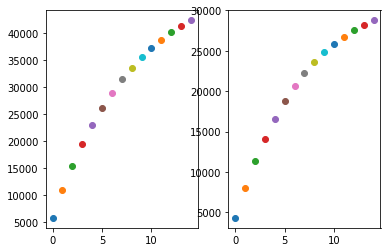

In [55]:
_gradient_descent(xsample,ysample)

これでlinear_hypothesisを更新することができた。   
n_thetaもしっかり収束している。

ここまで線形回帰のための関数を定義してきた。
ただ、毎回関数を呼び出すのは面倒である。  
また、lossの表示や予測のことも考えると、標準化した時と同様、クラス化した方が便利である。  
ここからはクラス化について考えていく。

## __線形回帰クラス__
- まずは最小二乗誤差の関数化

In [56]:
def MSE(y_pred, y):
        mse = np.average(np.square(y_pred - y), axis=0)/2
        return mse

In [92]:
class ScratchLinearRegression():
    """
    線形回帰
    ＊コンストラクタ（__init__）のパラメータはここに書いておくと分かりやすい

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, num_iter, lr, bias, verbose):
        # ハイパーパラメータを属性として記録
        self.num_iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        if self.bias:
            self.n_theta = np.random.randn(X.shape[1]+1)
        else:
            self.n_theta = np.random.randn(X.shape[1])
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.num_iter)
        self.val_loss = np.zeros(self.num_iter)
        
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        linear = np.dot(X, self.n_theta)
        linear = linear[:, np.newaxis]
        return linear

    def _gradient_descent(self, X, y):
            """
            最急降下法で重みを更新する。

            Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
              学習データ
            y : 次の形のndarray, shape (n_samples, 1)
              正解値

            Returns
            -------
              次の形のndarray, shape (1,)

            """
            diff = self._linear_hypothesis(X).ravel() - y
            self.n_theta = self.n_theta - 0.1  * np.average(diff * X.T, axis=1)
            return self.n_theta
    
    def _compute_cost(self, X, y):
        """
        平均二乗誤差を計算する。MSEは共通の関数を作っておき呼び出す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値

        Returns
        -------
          次の形のndarray, shape (1,)
          平均二乗誤差
        """
        y_pred = self._linear_hypothesis(X).ravel()
        y = y
        return MSE(y_pred, y)
        

    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        if self.bias:
            bias_col = np.ones(X.shape[0])
            X = np.hstack((X, bias_col[:,np.newaxis]))
            if X_val is not None:
                val_bias_col = np.ones(X_val.shape[0])
                X_val = np.hstack((X_val, val_bias_col[:,np.newaxis]))
            
        for i in range(self.num_iter):
            self._gradient_descent(X, y)
            loss = self._compute_cost(X, y)
            self.loss[i] = loss
            if (X_val is not None) and (y_val is not None):
                val_loss = self._compute_cost(X_val, y_val)
                self.val_loss[i] = val_loss
            else:
                self.val_loss[i] = None
                
            plt.subplot(1,2,1)
            plt.plot(i,self.n_theta[0], marker='o')
            plt.title('theta_1')
            plt.subplot(1,2,2)
            plt.plot(i, self.n_theta[1], marker='o')
            plt.title('theta2')
            plt.subplots_adjust(wspace=0.5)
            
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print('[{}]loss:   {} val_loss: {}'.format(i,self.loss[i], self.val_loss[i]))
                print('[{}]coef:   {}'.format(i,self.n_theta))
                print('-'*50)
                
        plt.show()


    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        if self.bias:
            bias_col = np.ones(X.shape[0])
            X = np.hstack((X, bias_col[:,np.newaxis]))
            predict = np.dot(self.n_theta, X.T)
            
        else:
            predict = np.dot(self.n_theta, X.T)
        
        return predict


In [133]:
def plot_loss(loss, val_loss, label1="train_loss", label2='val_loss', title="model_loss"):
    """
    損失をプロットする。

    Parameters
    ----------
    loss1 : 次の形のndarray, shape (n_iter,)
      損失の一覧
    loss2 : 次の形のndarray, shape (n_iter,)
      損失の一覧
    label1 : str
      ラベル名。デフォルトはtrain_loss
    label2 : str
      ラベル名。デフォルトはval_loss
    """
    plt.figure(figsize=(10,5))
    plt.plot(loss,"o-",label=label1,)
    plt.plot(val_loss,"o-",label=label2,)
    plt.title('{}'.format(title))
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()


## **バイアスなし線形回帰**

In [58]:
X_train = scaler.transform(X_train)

In [71]:
scaler.fit(X_test)
X_test=scaler.transform(X_test)

In [104]:
lr = ScratchLinearRegression( num_iter=20, lr=0.01, bias=False, verbose=True)

[0]loss:   19014263837.920803 val_loss: 19156615882.48527
[0]coef:   [5814.14606861 4300.52953522]
--------------------------------------------------
[1]loss:   18634305619.202274 val_loss: 18837472279.90011
[1]coef:   [10953.78451816  8045.02864548]
--------------------------------------------------
[2]loss:   18340532177.794983 val_loss: 18594707202.23142
[2]coef:   [15497.84302035 11303.05291276]
--------------------------------------------------
[3]loss:   18113338320.20943 val_loss: 18410468492.73323
[3]coef:   [19516.48290548 14136.23124092]
--------------------------------------------------
[4]loss:   17937587127.43381 val_loss: 18271030040.279106
[4]coef:   [23071.50609079 16598.50038833]
--------------------------------------------------
[5]loss:   17801590291.480362 val_loss: 18165843336.421997
[5]coef:   [26217.3586818  18737.05638644]
--------------------------------------------------
[6]loss:   17696321333.936764 val_loss: 18086806472.302517
[6]coef:   [29002.01347616 2059

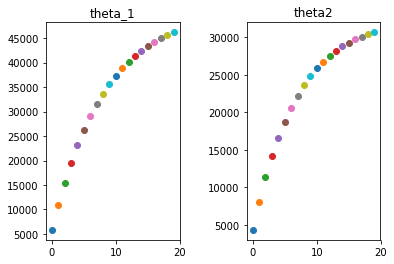

In [105]:
lr.fit(X_train, y_train,  X_test, y_test)

 - **sklearnのLinearRegressionと比べてみる。**  
 比べて見てみると、近い値になっているが少し外れている。グラフにすると、概形はfitしているようだが、完全にfitしていない。

In [106]:
sk_lr = LinearRegression().fit(X_train,y_train)

print("scratch_linear_regressionの係数：{}\nsklearn_linear_regressionの係数：{}".format(lr.n_theta,sk_lr.coef_))

scratch_linear_regressionの係数：[46214.63705842 30658.33329557]
sklearn_linear_regressionの係数：[51205.35334027 31851.93190439]


In [107]:
print("y:{}\nscratch_linear_regressionのy_pred:{}\nsklearn_linear_regressionのy_pred：{}".format(y_train[0:5],lr.predict(X_train), sk_lr.predict(X_train)))

y:[232000 201800 215000 176485 144000]
scratch_linear_regressionのy_pred:[ 45028.4215777   22874.43188336  59727.02929714 ...  99942.42820153
 -61725.66009808 -88170.6111151 ]
sklearn_linear_regressionのy_pred：[227989.07130917 206258.72103796 245119.7952108  ... 288622.03511492
 113226.68137747  85897.17480113]


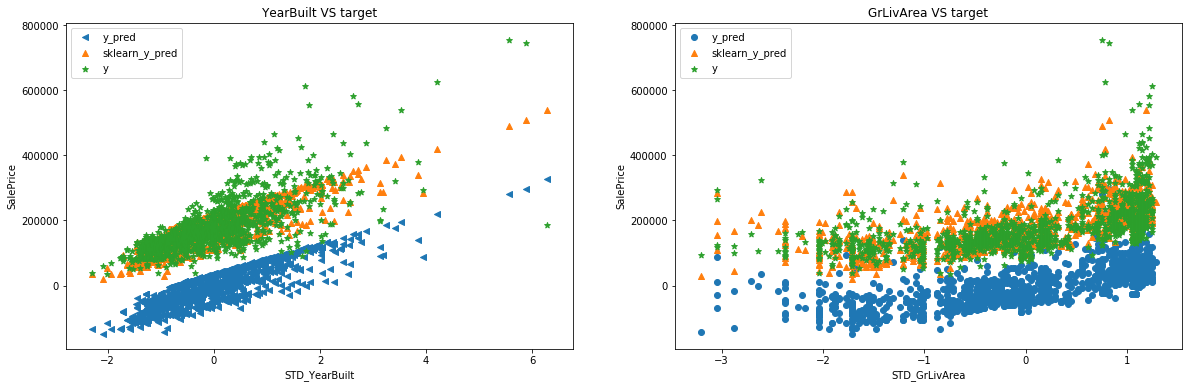

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].set_title("YearBuilt VS target")
ax[0].set_xlabel("STD_YearBuilt")
ax[0].set_ylabel("SalePrice")
ax[0].scatter(X_train[:,0:1],lr.predict(X_train),label="y_pred",marker="<")
ax[0].scatter(X_train[:,0:1],sk_lr.predict(X_train),label="sklearn_y_pred",marker="^")
ax[0].scatter(X_train[:,0:1],y_train, label="y", marker="*")
ax[0].legend()

ax[1].set_title("GrLivArea VS target")
ax[1].set_xlabel("STD_GrLivArea")
ax[1].set_ylabel("SalePrice")
ax[1].scatter(X_train[:,1:2],lr.predict(X_train), label="y_pred")
ax[1].scatter(X_train[:,1:2],sk_lr.predict(X_train),label="sklearn_y_pred", marker="^")
ax[1].scatter(X_train[:,1:2],y_train, label="y", marker="*"); 
ax[1].legend();

In [64]:
y_train

array([232000, 201800, 215000, ..., 335000, 115000, 115000])

## バイアスあり

In [113]:
bias_lr = ScratchLinearRegression( num_iter=20, lr=0.01, bias=True, verbose=True)

[0]loss:   15920185223.517609 val_loss: 16021059729.97966
[0]coef:   [ 5815.75562789  4300.53540931 18047.34242001]
--------------------------------------------------
[1]loss:   13034303651.47046 val_loss: 13158653553.420446
[1]coef:   [10955.23299348  8044.99884977 34288.74970198]
--------------------------------------------------
[2]loss:   10710731724.401398 val_loss: 10852484831.066315
[2]coef:   [15499.14729757 11302.99452527 48906.01625575]
--------------------------------------------------
[3]loss:   8839400659.472431 val_loss: 8993864379.670216
[3]coef:   [19517.65802761 14136.1502638  62061.55615415]
--------------------------------------------------
[4]loss:   7331897998.51358 val_loss: 7495454462.488872
[4]coef:   [23072.56546571 16598.40189565 73901.54206271]
--------------------------------------------------
[5]loss:   6117182222.42269 val_loss: 6287050887.542134
[5]coef:   [26218.31426599 18736.94465261 84557.52938041]
--------------------------------------------------
[6

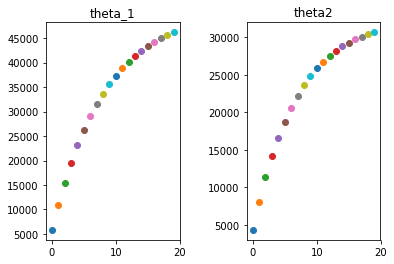

In [114]:
bias_lr.fit(X_train, y_train, X_test, y_test)

In [115]:
sk_lr = LinearRegression().fit(X_train,y_train)

print("scratch_linear_regressionの係数：{}\nsklearn_linear_regressionの係数：{} {}".format(bias_lr.n_theta,sk_lr.coef_, sk_lr.intercept_))

scratch_linear_regressionの係数：[ 46214.87620769  30658.23110807 158521.68231545]
sklearn_linear_regressionの係数：[51205.35334027 31851.93190439] 180461.41523972614


- trainとtestに対してpredict

In [116]:
print("y_true:{}\nscratch_linear_regressionのy_pred:{}\nsklearn_linear_regressionのy_pred：{}".format(y_train[0:5],bias_lr.predict(X_train)[0:5], sk_lr.predict(X_train)[0:5]))

y_true:[232000 201800 215000 176485 144000]
scratch_linear_regressionのy_pred:[203550.04573694 181396.28833635 218248.83359857 176922.1253869
  75904.92991042]
sklearn_linear_regressionのy_pred：[227989.07130917 206258.72103796 245119.7952108  198344.97271908
  92543.58221172]


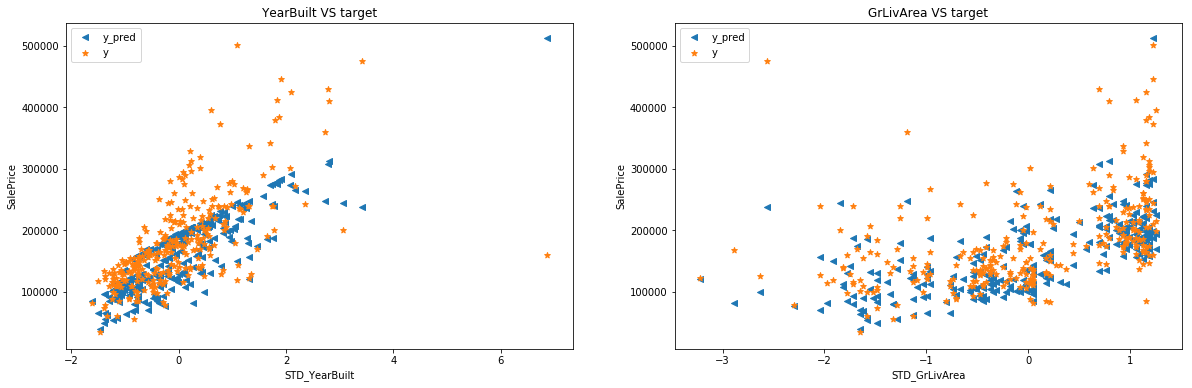

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].set_title("YearBuilt VS target")
ax[0].set_xlabel("STD_YearBuilt")
ax[0].set_ylabel("SalePrice")
ax[0].scatter(X_test[:,0:1],bias_lr.predict(X_test),label="y_pred",marker="<")
# ax[0].scatter(X_test[:,0:1],sk_lr.predict(X_test),label="sklearn_y_pred",marker="^")
ax[0].scatter(X_test[:,0:1],y_test, label="y", marker="*")
ax[0].legend()

ax[1].set_title("GrLivArea VS target")
ax[1].set_xlabel("STD_GrLivArea")
ax[1].set_ylabel("SalePrice")
ax[1].scatter(X_test[:,1:2],bias_lr.predict(X_test), label="y_pred", marker="<")
# ax[1].scatter(X_test[:,1:2],sk_lr.predict(X_test),label="sklearn_y_pred", marker="^")
ax[1].scatter(X_test[:,1:2],y_test, label="y", marker="*"); 
ax[1].legend();

バイアス有りの結果を見るとかなり値が近くなっていることがわかる。  
グラフの概形を見ても、ほとんど同じところにplotされていることがわかる。

## 学習曲線

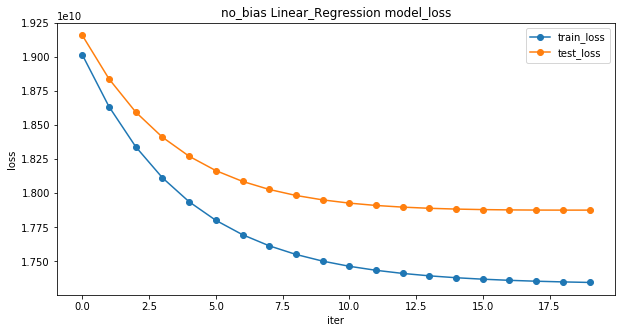

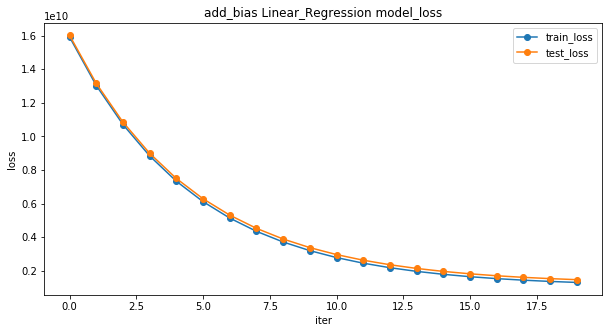

In [134]:
no_bias_loss = lr.loss
no_bias_val_loss = lr.val_loss
plot_loss(no_bias_loss, no_bias_val_loss,label1="train_loss", label2='test_loss', title="no_bias Linear_Regression model_loss")
plot_loss(bias_loss, bias_val_loss,label1="train_loss", label2='test_loss', title="add_bias Linear_Regression model_loss")

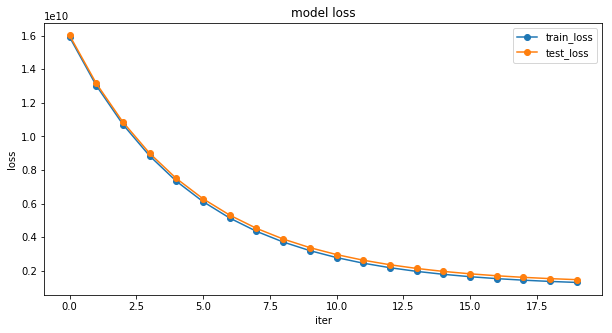

In [131]:
bias_loss = bias_lr.loss
bias_val_loss = bias_lr.val_loss
plot_loss(bias_loss, bias_val_loss,label1="train_loss", label2='test_loss')

In [75]:
class DammyParser():
    def __init__(self):
        self.iter = 5000
        self.lr = 1e-3
        self.verbose = True
        self.no_bias = False
        self.dataset = "train.csv"

args = DammyParser()